In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir("../")
from parc.model import model_burgers as model
import parc.data.data_burgers as data
!nvidia-smi

2024-05-24 12:39:42.644081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:39:43.315519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/:/usr/local/cuda/include/:/usr/local/cuda/lib/:/usr/local/cuda/lib64/:/usr/lib/x86_64-linux-gnu/:/opt/apps/TensorRT-8.6.1.6/lib/:/opt/apps/TensorRT-8.6.1.6/include/:/usr/include/x86_64-linux-gnu/:/usr/include/
2024-05-24 12:39:43.315918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libn

Fri May 24 12:39:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10                     Off | 00000000:A6:00.0 Off |                    0 |
|  0%   40C    P0              39W / 150W |  20980MiB / 23028MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2024-05-24 12:39:44.145640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:39:44.278142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20741 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:a6:00.0, compute capability: 8.6


In [9]:
burgers_data = data.DataBurgers()
R_list = [7500]
a_list = [0.9]
w_list = [0.8]
clipped_data = burgers_data.clip_raw_data(R_list,a_list,w_list, purpose = 'training')

# Validation

In [10]:
R_list_test = [3000]
a_list_test = [1.00]
w_list_test = [0.85]
clipped_data_test = burgers_data.clip_raw_data( R_list_test, a_list_test, w_list_test, sequence_length = 100, purpose = 'validation')

## Load model from weight files

In [11]:
tf.keras.backend.clear_session()
parc = model.PARCv2_burgers(n_time_step = 100, step_size = 1/100, solver = "heun")
parc.differentiator.load_weights('./Pretrained_Weights/burgers/parc2_diff_burgers_heun.h5')
parc.integrator.load_weights('./Pretrained_Weights/burgers/parc2_int_burgers_heun.h5')

## Make prediction on the test set

In [12]:
prediction_data = []
for j in range(1):
    input_seq_current = tf.cast(clipped_data_test[j:j+1,:,:,:3], dtype = tf.float32)
    res = parc.predict(input_seq_current)
    prediction_data.append(res)
    print('Finish case ', j)
prediction_data = np.concatenate(prediction_data, axis = 0)

1/1 [==============================] - 84s 84s/step
Finish case  0


In [6]:
#np.save('./results/burgers/parcv2_burgers.npy',prediction_data)

(1, 64, 64, 203)


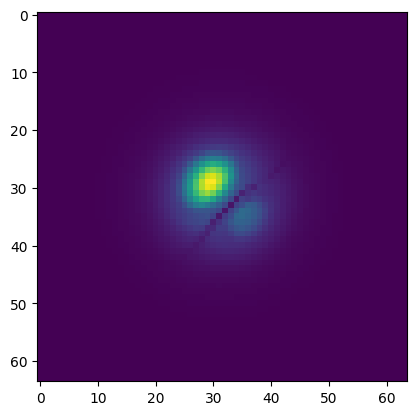

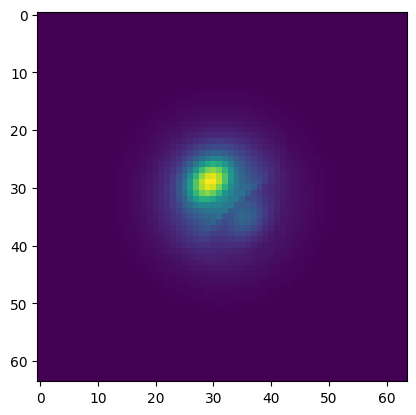

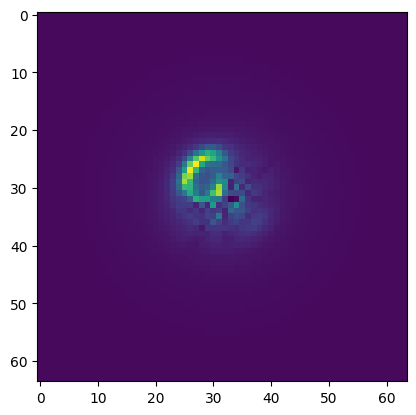

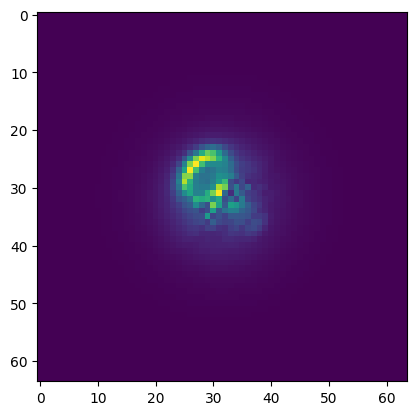

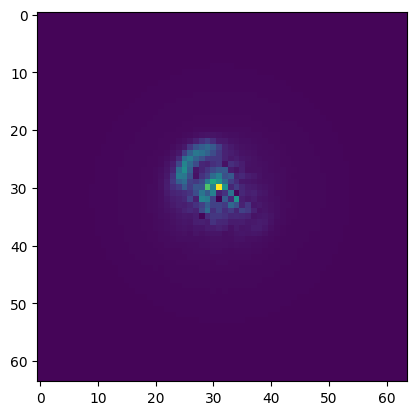

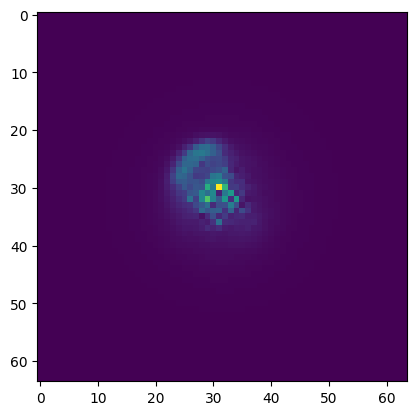

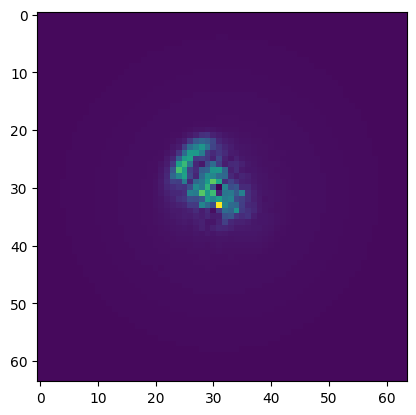

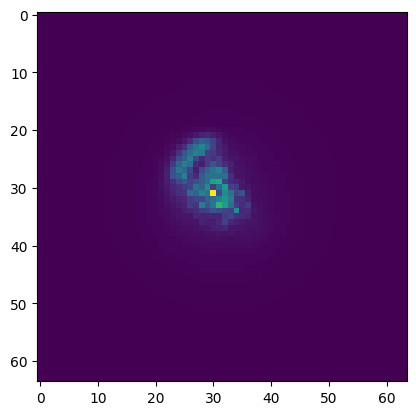

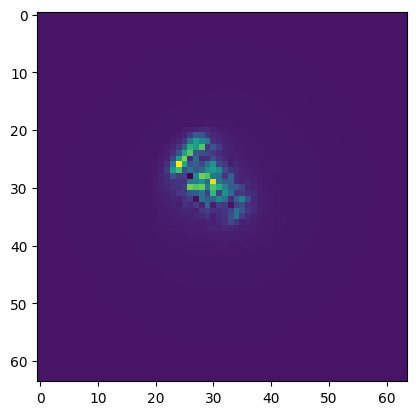

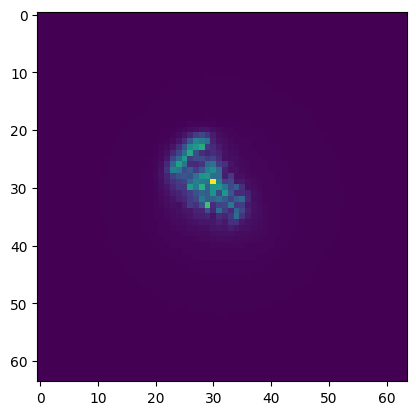

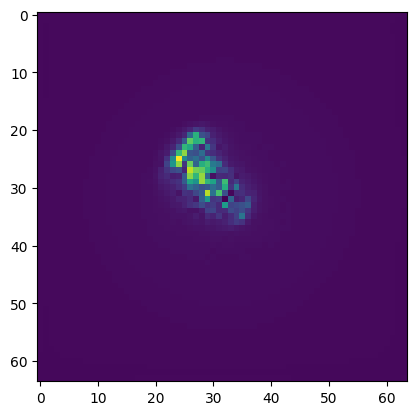

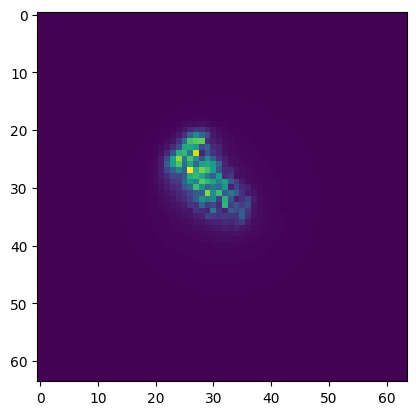

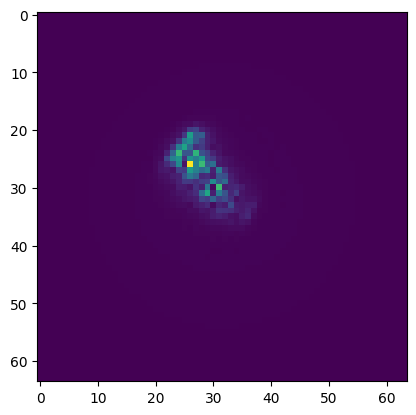

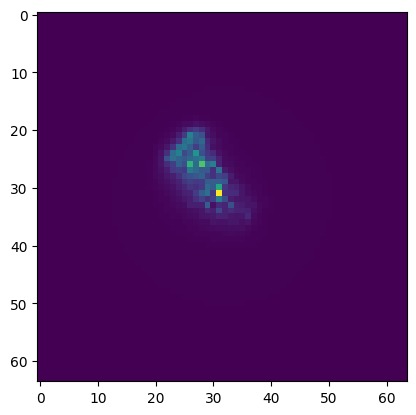

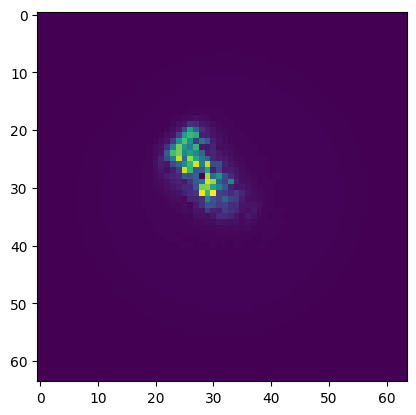

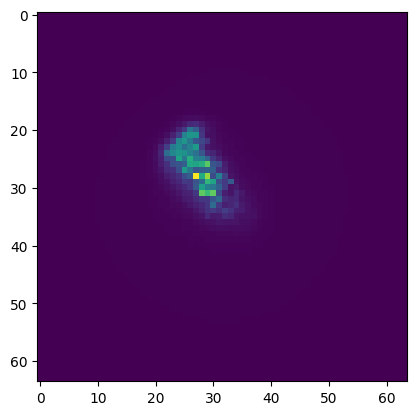

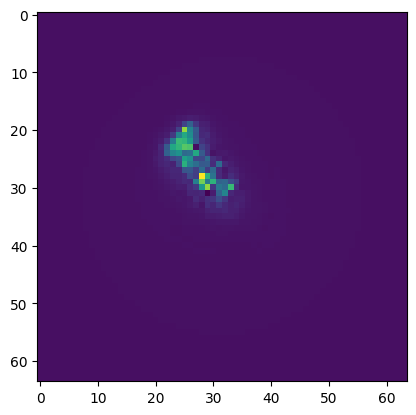

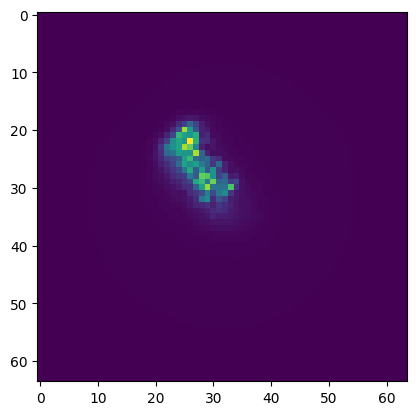

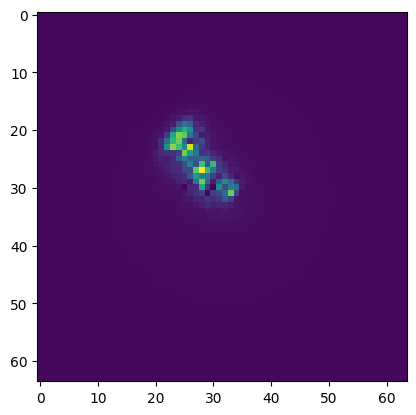

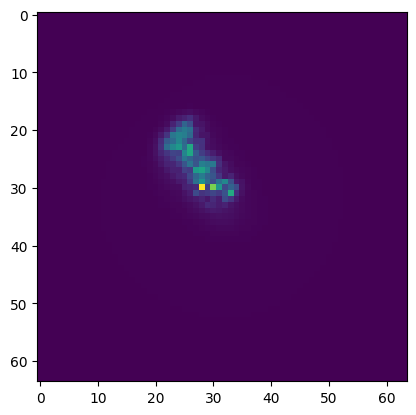

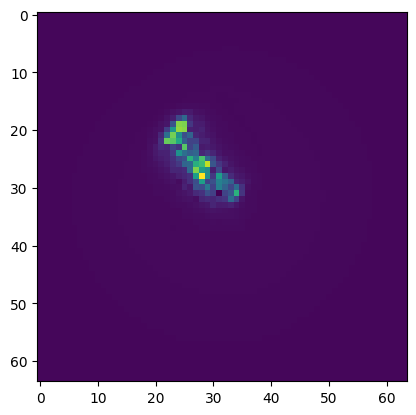

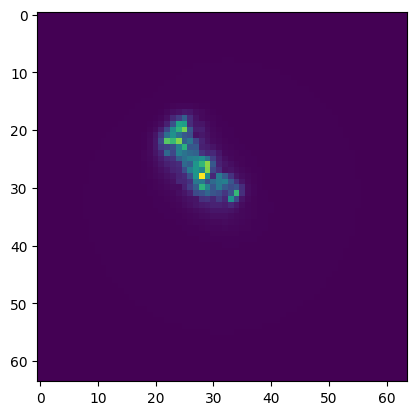

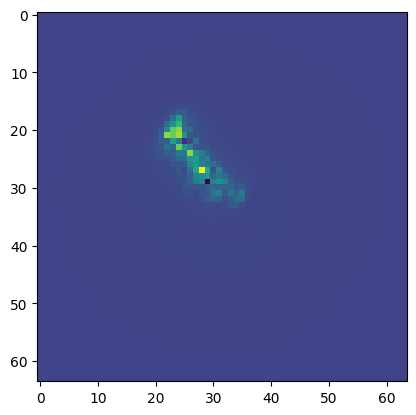

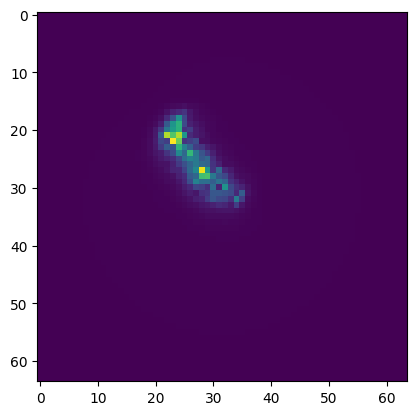

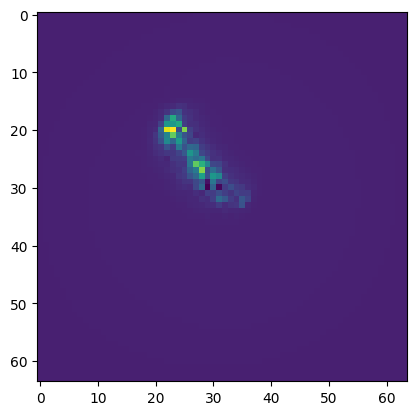

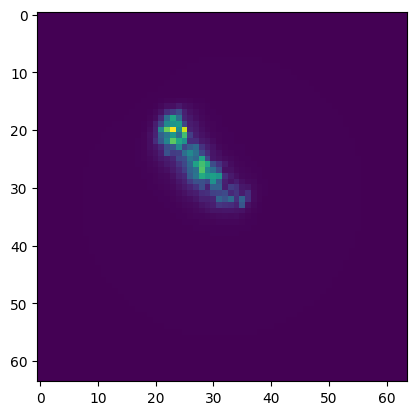

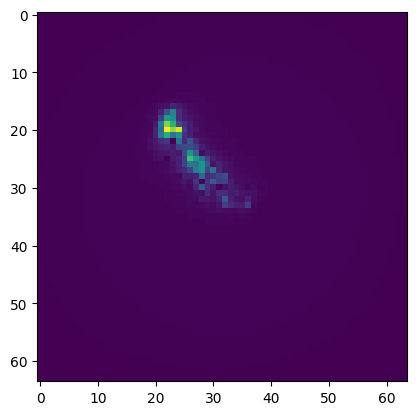

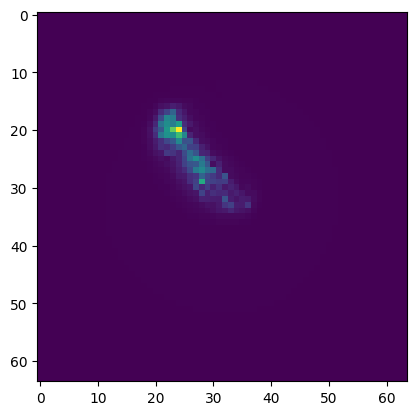

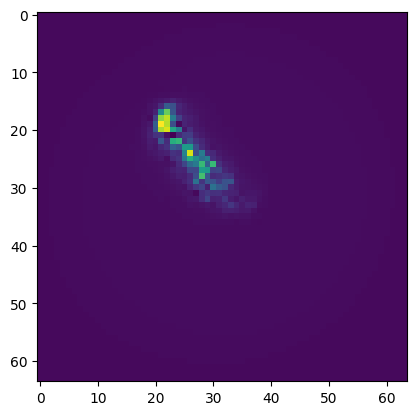

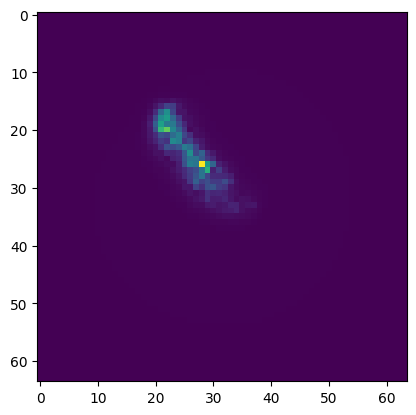

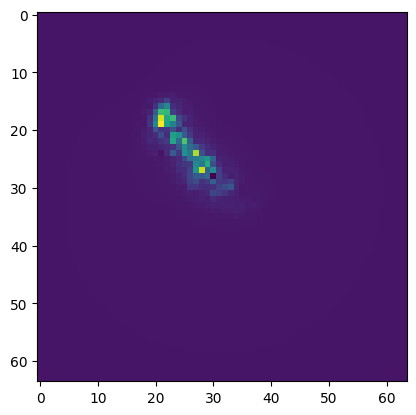

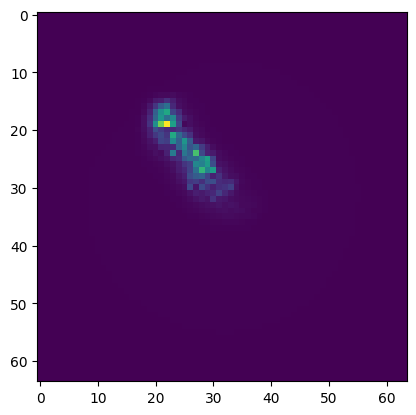

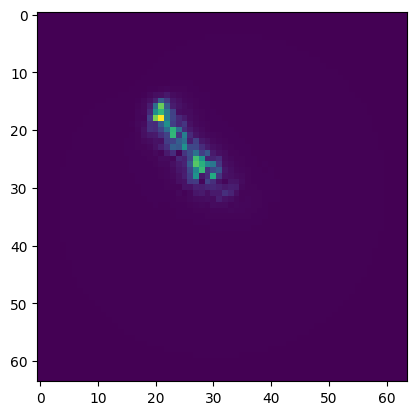

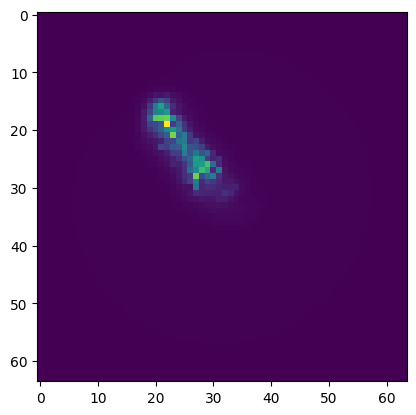

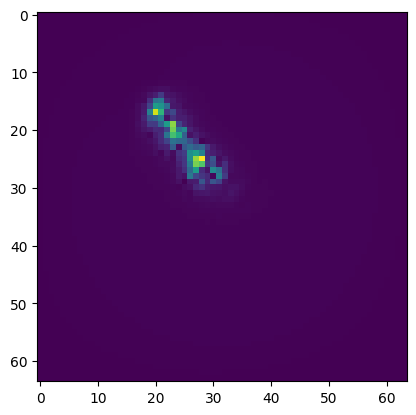

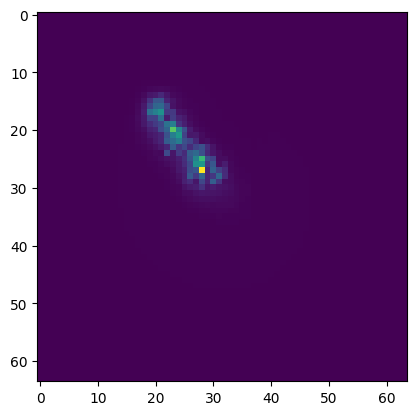

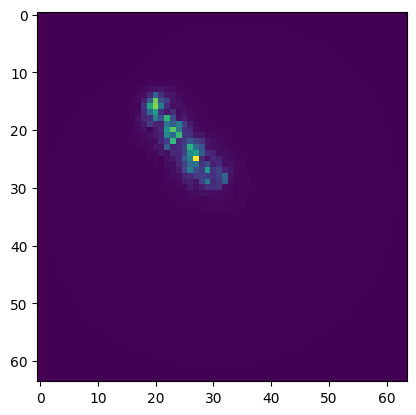

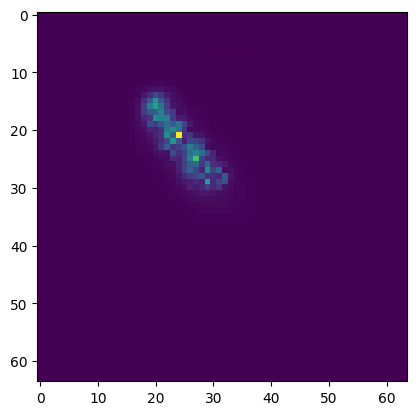

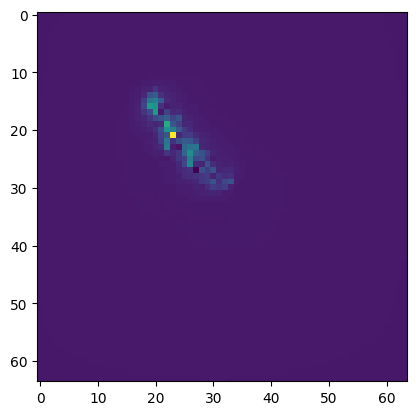

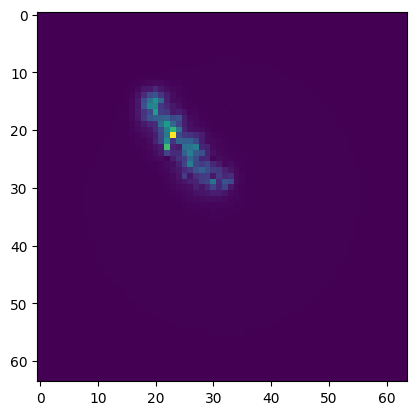

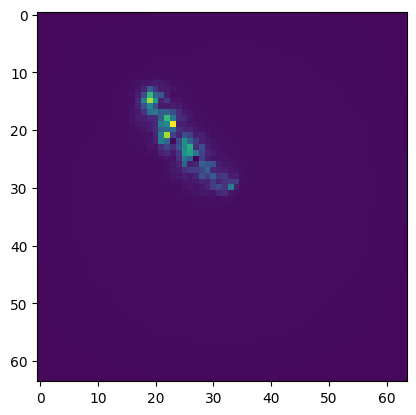

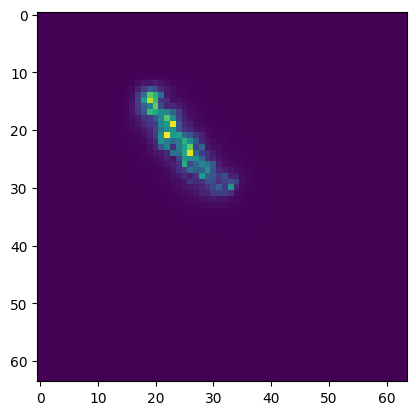

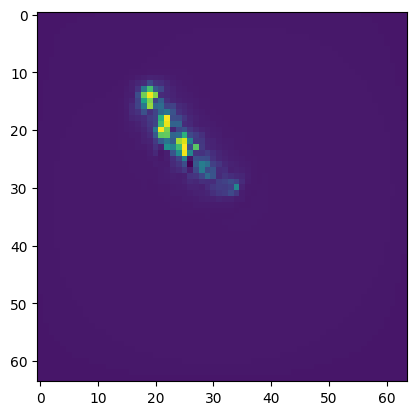

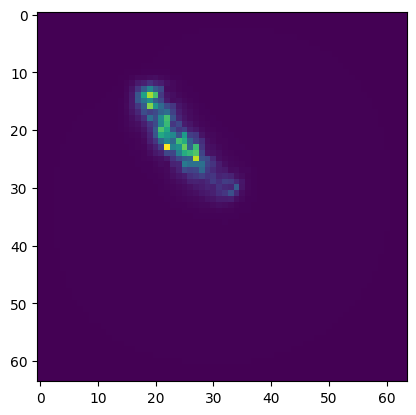

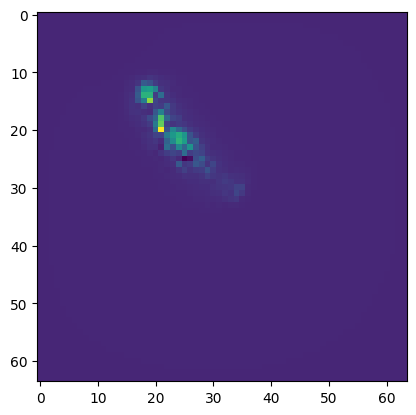

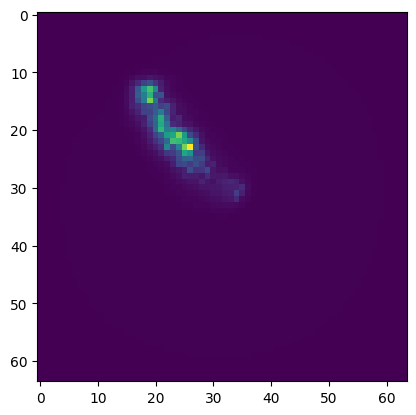

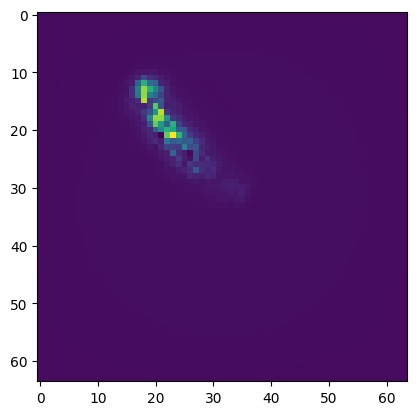

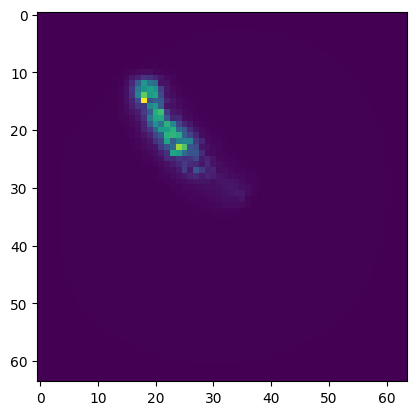

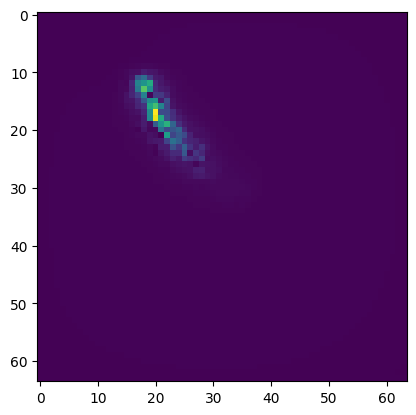

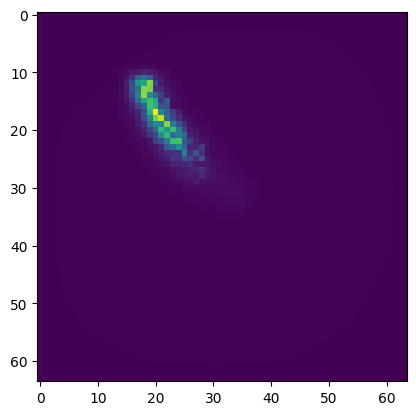

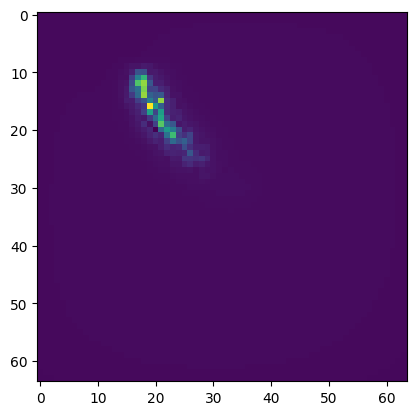

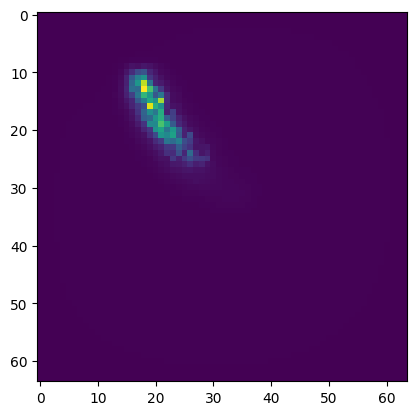

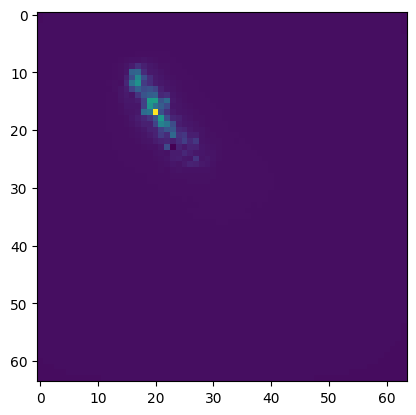

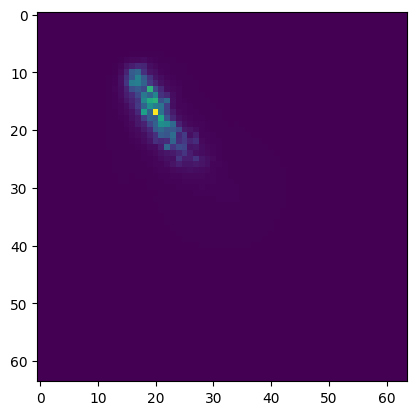

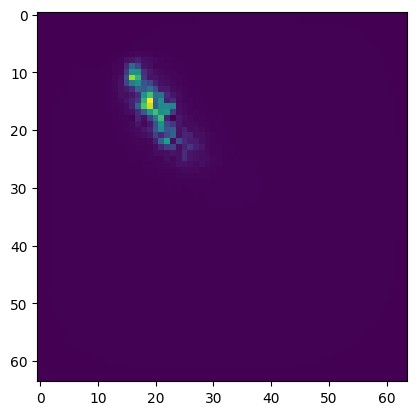

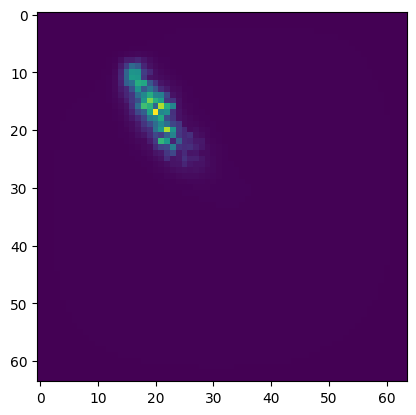

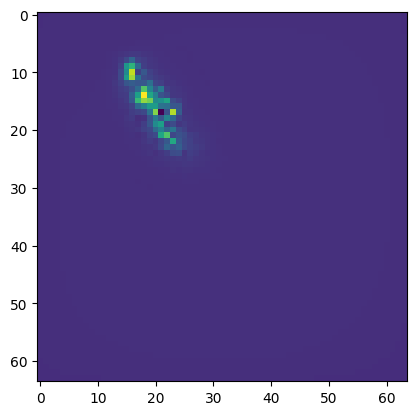

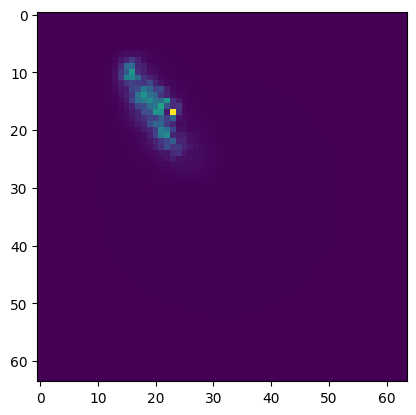

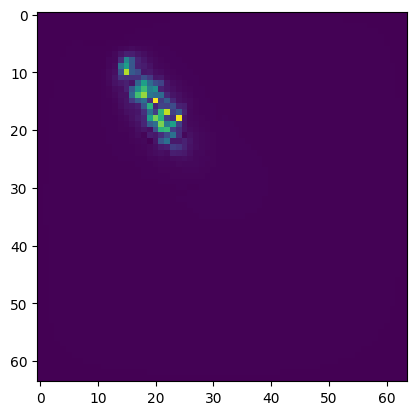

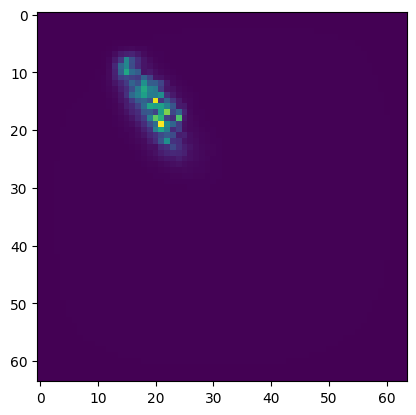

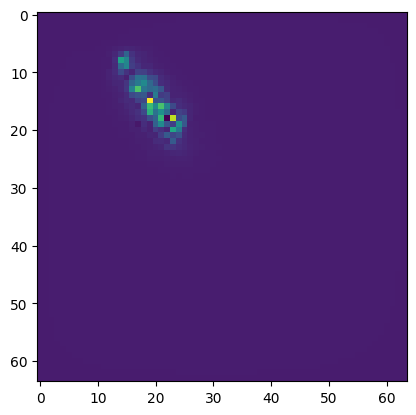

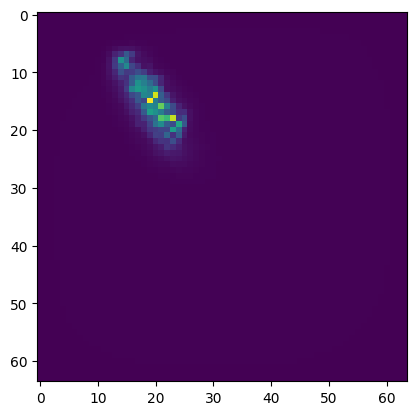

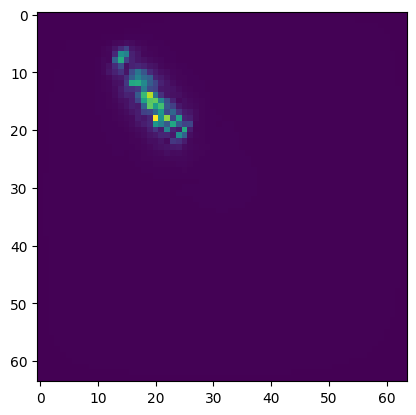

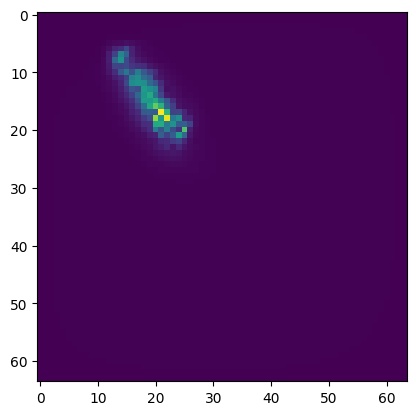

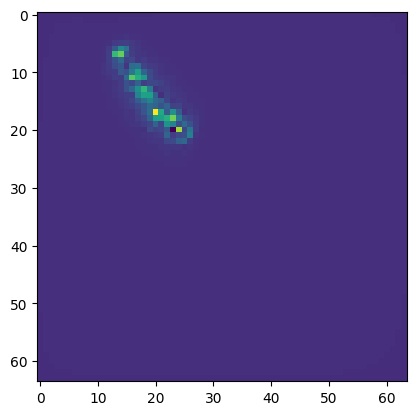

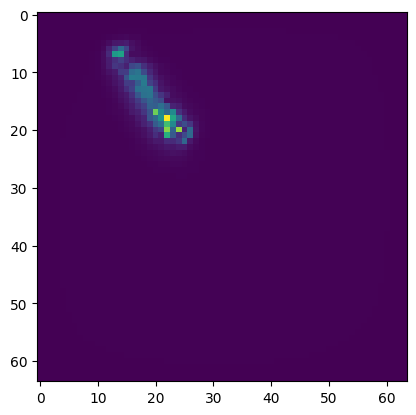

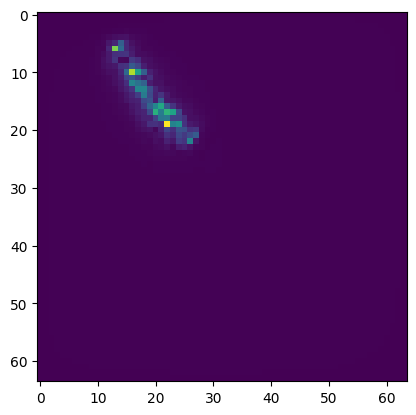

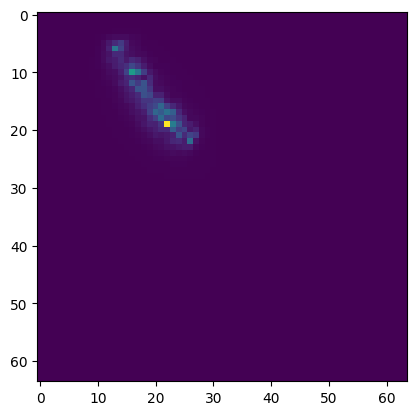

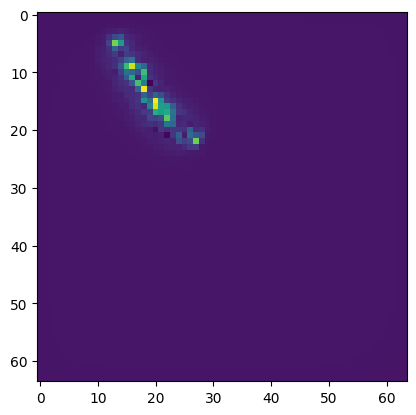

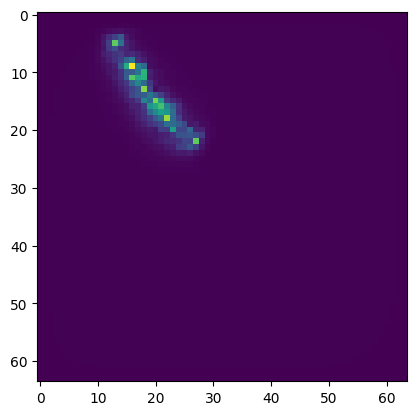

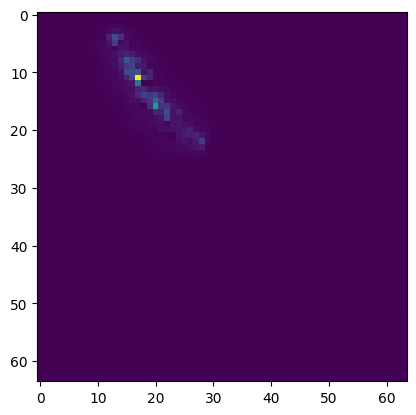

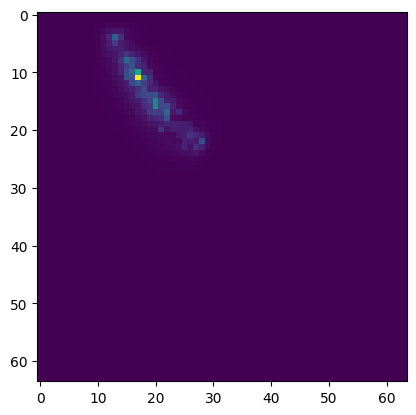

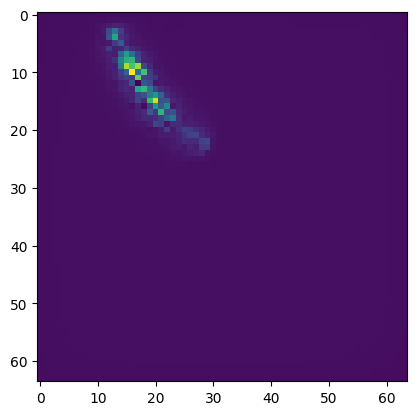

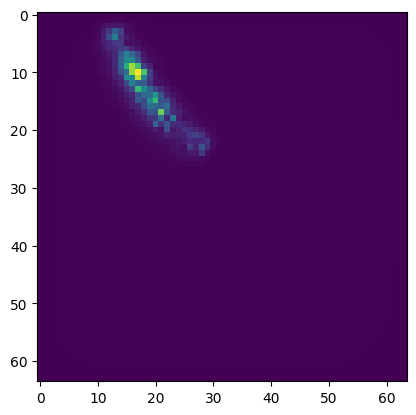

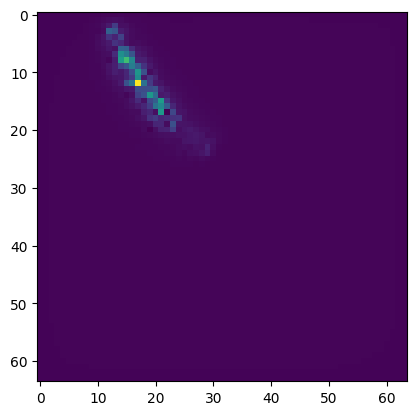

In [13]:
print(prediction_data.shape)
for i in range(75):
    plt.imshow(prediction_data[0,:,:,(i)+3])
    plt.show()